C:\Miniconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


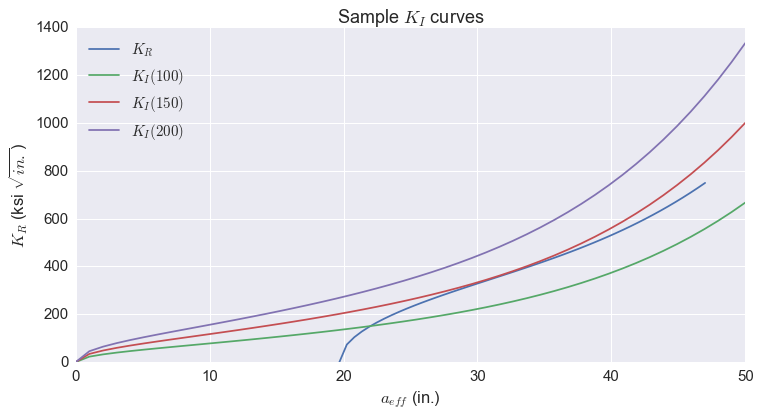

In [1]:
import numpy as np  
from scipy.optimize import minimize  
from matplotlib import pyplot as plt  
import seaborn as sb
sb.set(font_scale=1.5)
%matplotlib inline

def ki(a,a0=19.69,W=78.74,B=0.063,P=100):  
    return P/(B*W)*a**.5*(1.122-.231*a/W + 10.55*(a/W)**2 - 21.71*(a/W)**3+30.82*(a/W)**4)  
      
def ki_e(a,P,a0=19.69,W=78.74,B=0.063):  
    s = P/(B*W)  
    adiff = 2*a  
    i = 0  
    while (adiff < 0.01*a and i < 10):  
        aold = a          
        a = a + 1/(2*np.pi)*(ki(a)/s)**2  
        adiff = a - aold  
        i += 1  
    return P/(B*W)*a**.5*(1.12-.231*a/W + 10.55*(a/W)**2 - 21.71*(a/W)**3+30.82*(a/W)**4)  
      
def kr(a,a0=7.5,W=60.,B=0.063,P=210.):#in inches, K_R in ksi sqrt(in)  
    s = P/(B*W)  
    adiff = 2*a  
    i = 0  
    while (adiff < 0.01*a and i < 10):  
        aold = a          
        a = a + 1/(2*np.pi)*(ki(a)/s)**2  
        adiff = a - aold  
        i += 1  
    da = a - a0  
    return s*(np.pi*da)**.5*(1+.128*2*da/W-.288*(2*da/W)**2+1.525*(2*da/W)**3)  
      
def dki(a,P,a0=50.,W=200.):  
    return (ki_e(a+.01,P,a0=19.69,W=78.74)-ki_e(a-.01,P,a0=19.69,W=78.74))/.02  
      
def dkr(a,a0=50.,W=200.,P=210.):  
    return (kr(a+.01,a0=19.69,W=78.74,P=275)-kr(a-.01,a0=19.69,W=78.74,P=275))/.02  
  
def f1(x):  
    return (dkr(x[0],a0=19.69,W=78.74,P=275)-dki(x[0],x[1],a0=19.69,W=78.74))**2 + (kr(x[0],a0=19.69,W=78.74,P=275)-ki_e(x[0],x[1],a0=19.69,W=78.74))**2  
    
x0 = [32.,150.]  
res = minimize(f1, x0, bounds=((0,None),(0,None)))  
  
a = np.linspace(7.5,17.5)  
a1 = np.linspace(19.69,47)  
a2 = np.linspace(2,5.5)  
a0 = np.linspace(0,50)

plt.figure(figsize=(12,6))  
plt.plot(a1,[kr(i,a0=19.69,W=78.74,P=275) for i in a1],label='$K_R$')  
plt.plot(a0,[ki_e(i,100) for i in a0],label='$K_I(100)$')  
plt.plot(a0,[ki_e(i,150) for i in a0],label='$K_I(150)$')  
plt.plot(a0,[ki_e(i,200) for i in a0],label='$K_I(200)$')  
plt.xlabel('$a_{eff}$ (in.)')  
plt.ylabel('$K_R$ (ksi $\sqrt{in.}$)')  
plt.title('Sample $K_I$ curves')  
plt.legend(loc='best')  

In [2]:
res

   status: 0
  success: True
     nfev: 27
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      fun: 2.4431661797454219e-13
        x: array([  31.95346354,  148.69222248])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
      jac: array([  8.20125987e-07,   1.26850152e-06])
      nit: 8